In [1]:
from forwarder import *

from matplotlib import pyplot as plt
from sklearn import linear_model as lm
from scipy import stats

In [9]:
np.random.random()

0.07420072524168575

# Run simulation experiment

In [329]:
model_time = 4
launches = 1000
disp_num = range(1, 8)
req_itv = [i * 0.1 for i in range(2, 10)]
tariff = [4 + i * 0.5 for i in range(9)]

risks = []

# set freight forwarder
ff = FreightForwarder()
ff.costs_1h = 2.5
ff.costs_1h_paid = 2

# run experiment
for t in tariff:
    # set tariff
    ff.tariff = t
    mtx = []
    for dn in disp_num:
        row = []
        # set dispatchers
        ff.dispatchers = [Dispatcher(name=f'D#{i+1}') for i in range(dn)]
        for itv in req_itv:
            # set requests flow
            rf = RequestsFlow(s_itv=Stochastic(law='expon', scale=itv),
                            model_time=model_time)
            positive = 0
            for launch in range(launches):
                # generate demand
                rf.generate()
                # simulate servicing and calculate profit
                ff.reset()
                positive += ff.serve(rf)['profit'] <= 0
            row.append(positive/launches)
        mtx.append(row)
    risks.append(mtx)

# Visualize experiment results

In [330]:
def plot_2D(risks):
    risks = np.array(risks)
    plt.figure(dpi=120)
    for col in range(risks.shape[1]):
        plt.plot(disp_num, risks[:, col], label=f'{req_itv[col]:.1f} hours')
    plt.xlabel('Dispatchers\' number', fontsize=12)
    plt.ylabel('Risk of entering the market', fontsize=12)
    plt.legend(fontsize=12)
    plt.title('a', fontsize=12, loc='left', y=1, pad=10)
    plt.show()
    plt.figure(dpi=120)
    for row in range(risks.shape[0]):
        plt.plot(req_itv, risks[row, :], label=f'#dispatchers={disp_num[row]}')
    plt.xlabel('Requests\' interval [hours]', fontsize=12)
    plt.ylabel('Risk of entering the market', fontsize=12)
    plt.legend(fontsize=12)
    plt.title('b', fontsize=12, loc='left', y=1, pad=10)
    plt.show()

In [331]:
def plot_3D(Y, X, axes=(0, 1), place=0, ttl=None):
    
    ylabel = list(Y.keys())[0]
    ys = np.array(list(Y.values())[0])
    xlabels = list(X.keys())
    xs = np.array(list(X.values()), dtype=object)

    gdata = []
    for i in range(ys.shape[axes[0]]):
        for j in range(ys.shape[axes[1]]):
            if axes == (0, 1):
                value = ys[i][j][place]
            elif axes == (1, 0):
                value = ys[j][i][place]
            elif axes == (1, 2):
                value = ys[place][i][j]
            elif axes == (2, 1):
                value = ys[place][j][i]
            elif axes == (0, 2):
                value = ys[i][place][j]
            elif axes == (2, 0):
                value = ys[j][place][i]
            else:
                value = None
            gdata.append([xs[axes[0]][i], xs[axes[1]][j], value])
            
    gdata = np.array(gdata)
    
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(xlabels[axes[0]])
    ax.set_ylabel(xlabels[axes[1]])
    ax.set_zlabel(ylabel)
    shape = (ys.shape[axes[0]], ys.shape[axes[1]])
    ax.plot_surface(np.reshape(gdata[:, 0], shape),
                    np.reshape(gdata[:, 1], shape),
                    np.reshape(gdata[:, 2], shape),
                    alpha=0.8)
    ax.set_title(ttl, fontsize=12, loc='left', y=0, pad=-20)
    plt.show()

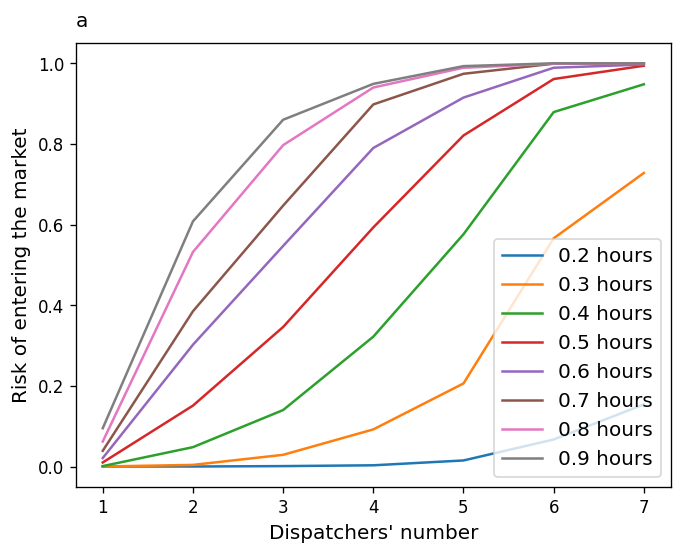

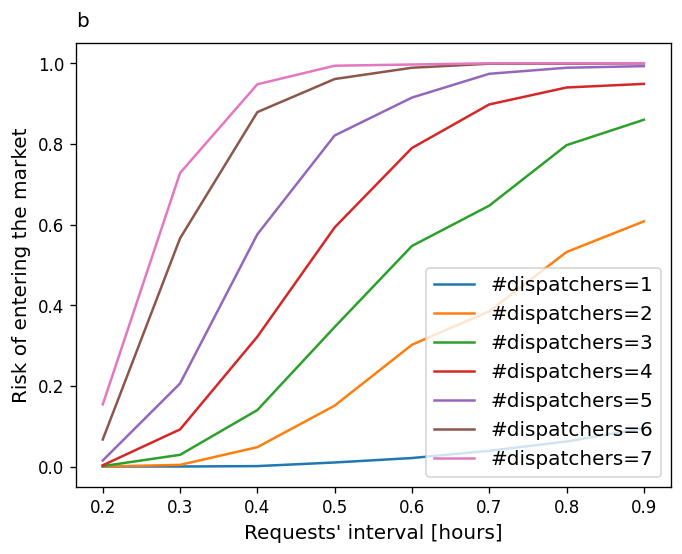

In [332]:
plot_2D(risks[3])

In [355]:
print(np.array(risks).shape)
Y={'Estimated risk': risks}
X={'Forwarder\'s tariff [$/request]': tariff,
    'Dispatchers\' number': disp_num,
    'Requests\' interval [hours]': req_itv}

(9, 7, 8)


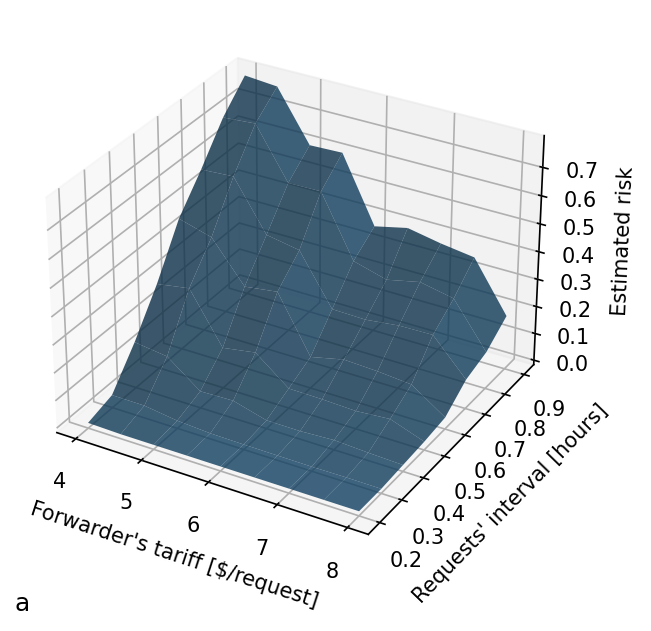

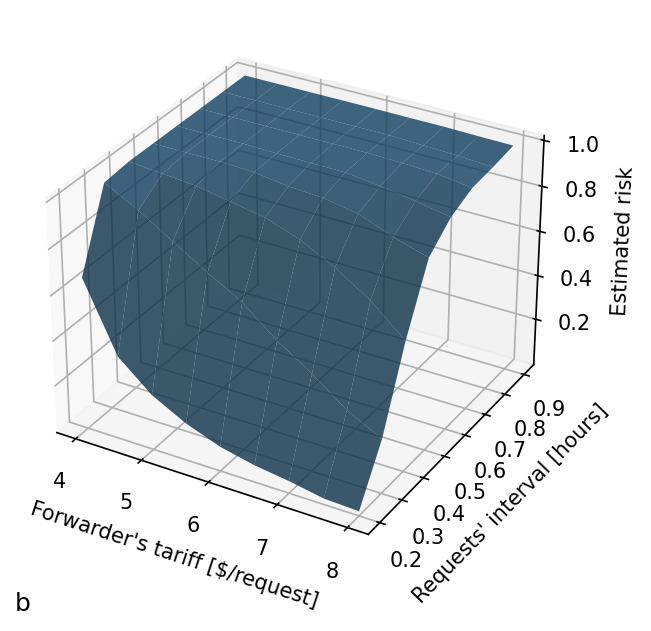

In [335]:
plot_3D(Y, X, axes=(0, 2), place=1, ttl='a')
plot_3D(Y, X, axes=(0, 2), place=6, ttl='b')

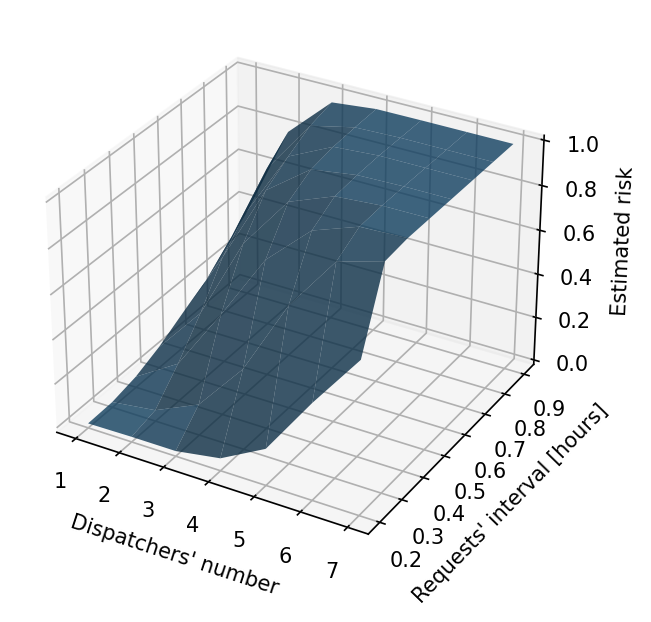

In [336]:
plot_3D(Y, X, axes=(1, 2), place=0)

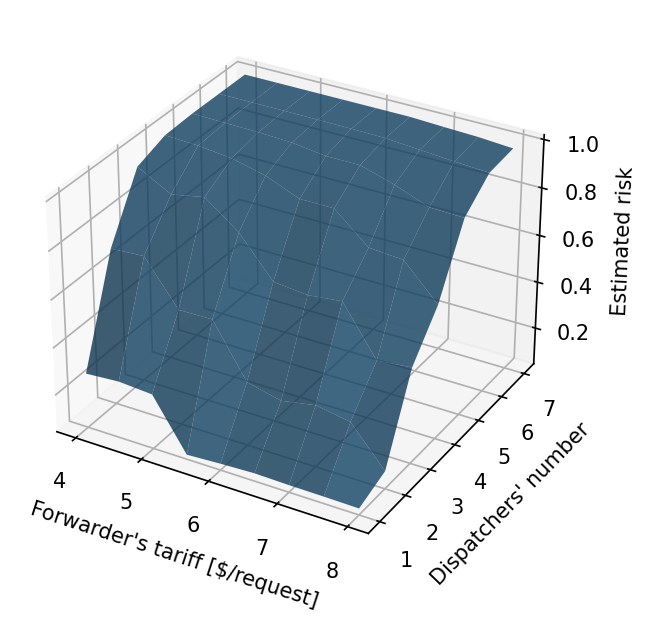

In [337]:
plot_3D(Y, X, axes=(0, 1), place=6)

# Regression analysis

In [338]:
def make_regression(X, Y, intercept=True, alpha=0.05, verbose=False):
    '''
    Performs the regression analysis:
    * calculates coefficients for multiple linear regression
    * estimates the coefficient of determination
    * provides confidence intervals for the given alpha
    Arguments:
    X - explanatory variables
    Y - an explained variable
    alpha - significance level
    Returns the fitted model, the determination coefficient, and confidence intervals
    '''
    rmodel = lm.LinearRegression(fit_intercept=intercept)
    # estimate regression coefficients
    rmodel.fit(X, Y)
    if verbose:
        print(f'intercept={rmodel.intercept_:.6f}')
        print(f'coefs={rmodel.coef_}')
    # get the model predictions
    mY = rmodel.predict(X)
    # calculate residuals
    errors = mY - Y
    # calculate empirical average of the explained variable
    avgY = Y.mean()
    # estimate the coefficient of determination
    r2 = 1 - sum([e*e for e in errors]) / sum([(y - avgY)**2 for y in Y])
    if verbose: print(f'R2={r2:.6f}')
    # calculate the number of the degrees of freedom
    df = len(X) - len(rmodel.coef_) - 1
    s2 = sum([e*e for e in errors]) / df
    # get t-variable for the provided alpha and estimated df
    t_alpha = stats.t.ppf(1 - alpha / 2, df)
    if verbose: print(f't_alfa({alpha},{df})={t_alpha:.6f}')
    XTX = X.T.dot(X)
    invXTX = np.matrix(XTX).I
    # calculate confidence intervals
    bounds = {}
    for i in range(len(rmodel.coef_)):
        if invXTX[i, i] > 0:
            LB = rmodel.coef_[i] - t_alpha * np.sqrt(s2 * invXTX[i, i])
            UB = rmodel.coef_[i] + t_alpha * np.sqrt(s2 * invXTX[i, i])
            bounds[i] = (LB, UB)
            if verbose: print(f'coef{i + 1}\t{LB*UB > 0}\t{LB:.6f}\t{UB:.6f}')
    return rmodel, r2, bounds

#### Hypothesis #1: $$risk = b_0 + b_1 \cdot tariff + b_2 \cdot dispatchers + b_3 \cdot interval$$

In [339]:
X1 = np.array([[t, d, i] for t in tariff for d in disp_num for i in req_itv])
# X1 = np.array([[d, i] for d in disp_num for i in req_itv])
Y1 = np.array(risks).flatten()
# Y1 = np.array(risks[5]).flatten()
make_regression(X1, Y1, intercept=True, verbose=True)

intercept=-0.122500
coefs=[-0.07838393  0.13113641  1.01429327]
R2=0.836552
t_alfa(0.05,500)=1.964720
coef1	True	-0.084712	-0.072056
coef2	True	0.124506	0.137767
coef3	True	0.958241	1.070345


(LinearRegression(),
 0.8365519713515258,
 {0: (-0.08471170357624941, -0.0720561535666078),
  1: (0.12450556897268823, 0.13776724848762917),
  2: (0.9582411587021397, 1.0703453870272637)})

In [340]:
make_regression(X1, Y1, intercept=False, verbose=True)

intercept=0.000000
coefs=[-0.09201108  0.12735109  0.97463753]
R2=0.833636
t_alfa(0.05,500)=1.964720
coef1	True	-0.098395	-0.085627
coef2	True	0.120661	0.134041
coef3	True	0.918088	1.031187


(LinearRegression(fit_intercept=False),
 0.8336361920630465,
 {0: (-0.098395049877461, -0.08562711652294255),
  1: (0.12066136530568143, 0.13404081069420654),
  2: (0.9180876658178171, 1.0311873979451793)})

#### Hypothesis #3: $$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot \ln(dispatchers) + b_3 \cdot \ln(interval)$$

In [341]:
X3 = np.array([[np.log(t), np.log(d), np.log(i)] for t, d, i in X1])
# X3 = np.array([[np.log(d), np.log(i)] for d, i in X1])
Y3 = np.copy(Y1)
make_regression(X3, Y3, intercept=True, verbose=True)

intercept=1.145558
coefs=[-0.45637883  0.40974848  0.49588147]
R2=0.849177
t_alfa(0.05,500)=1.964720
coef1	True	-0.475464	-0.437294
coef2	True	0.388859	0.430638
coef3	True	0.468109	0.523654


(LinearRegression(),
 0.8491773131317724,
 {0: (-0.47546413505992663, -0.43729352090775536),
  1: (0.38885936852849856, 0.4306376003640352),
  2: (0.4681094370164972, 0.5236535109166587)})

In [342]:
make_regression(X3, Y3, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.12861326 0.45937563 0.44646528]
R2=0.731186
t_alfa(0.05,500)=1.964720
coef1	True	0.103134	0.154093
coef2	True	0.431488	0.487263
coef3	True	0.409389	0.483542


(LinearRegression(fit_intercept=False),
 0.7311861087134662,
 {0: (0.10313371110036426, 0.15409280119447658),
  1: (0.43148794113937, 0.4872633256168743),
  2: (0.40938864803824987, 0.48354190778901945)})

#### Hypothesis #5: $$risk = b_0 \cdot {tariff}^{b_1} \cdot {dispatchers}^{b_2} \cdot {interval}^{b_3}$$

In [343]:
X5 = np.copy(X3)
Y5 = np.array([np.log(y+1e-6) for y in Y1])
make_regression(X5, Y5, intercept=True, verbose=True)

intercept=3.624841
coefs=[-3.34249179  2.75099451  4.7646585 ]
R2=0.689301
t_alfa(0.05,500)=1.964720
coef1	True	-3.589042	-3.095941
coef2	True	2.481142	3.020847
coef3	True	4.405890	5.123427


(LinearRegression(),
 0.6893005200823838,
 {0: (-3.5890423120860135, -3.095941276385332),
  1: (2.4811417742608586, 3.020847247841101),
  2: (4.405889836657833, 5.123427161522878)})

In [344]:
make_regression(X5, Y5, intercept=False, verbose=True)

intercept=0.000000
coefs=[-1.49142634  2.90802758  4.60829294]
R2=0.674717
t_alfa(0.05,500)=1.964720
coef1	True	-1.743697	-1.239156
coef2	True	2.631914	3.184141
coef3	True	4.241201	4.975385


(LinearRegression(fit_intercept=False),
 0.6747172967386725,
 {0: (-1.7436966474763382, -1.2391560271430326),
  1: (2.6319144544004116, 3.184140701604538),
  2: (4.241201107407054, 4.975384775233428)})

#### Hypothesis #7: $$1-risk = b_0 \cdot {tariff}^{b_1} \cdot {dispatchers}^{b_2} \cdot {interval}^{b_3}$$

In [345]:
X7 = np.copy(X3)
Y7 = np.array([np.log(1 - y + 1e-6) for y in Y1])
make_regression(X7, Y7, intercept=True, verbose=True)

intercept=-10.336544
coefs=[ 5.29848901 -2.87037486 -3.14940963]
R2=0.519550
t_alfa(0.05,500)=1.964720
coef1	True	4.984718	5.612260
coef2	True	-3.213801	-2.526949
coef3	True	-3.605994	-2.692825


(LinearRegression(),
 0.5195497517056824,
 {0: (4.984718398398603, 5.612259625581504),
  1: (-3.213800858978538, -2.5269488536352336),
  2: (-3.605993799124735, -2.6928254608033493)})

In [346]:
make_regression(X7, Y7, intercept=False, verbose=True)

intercept=0.000000
coefs=[ 0.02001705 -3.31816812 -2.70351983]
R2=0.406330
t_alfa(0.05,500)=1.964720
coef1	False	-0.328770	0.368804
coef2	True	-3.699920	-2.936416
coef3	True	-3.211058	-2.195981


(LinearRegression(fit_intercept=False),
 0.40633015274906936,
 {0: (-0.3287701601429049, 0.3688042609036119),
  1: (-3.699920241075458, -2.9364159975011166),
  2: (-3.2110584929319126, -2.1959811604319848)})

#### <b>Hypothesis #9:</b> $$risk = b_0 + b_1 \cdot tariff + b_2 \cdot \ln(dispatchers) + b_3 \cdot \ln(interval)$$

In [347]:
X9 = np.array([[t, np.log(d), np.log(i)] for t, d, i in X1])
Y9 = np.copy(Y1)
make_regression(X9, Y9, intercept=True, verbose=True)

intercept=0.809168
coefs=[-0.07838393  0.40974848  0.49588147]
R2=0.848746
t_alfa(0.05,500)=1.964720
coef1	True	-0.083552	-0.073216
coef2	True	0.389699	0.429798
coef3	True	0.468712	0.523051


(LinearRegression(),
 0.8487460966726568,
 {0: (-0.08355159008224694, -0.07321626706061027),
  1: (0.3896992082384329, 0.42979776065410064),
  2: (0.4687122964456406, 0.523050651487515)})

In [348]:
make_regression(X9, Y9, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.02415513 0.49604413 0.40995265]
R2=0.703822
t_alfa(0.05,500)=1.964720
coef1	True	0.016924	0.031386
coef2	True	0.467988	0.524100
coef3	True	0.371934	0.447972


(LinearRegression(fit_intercept=False),
 0.703821990321216,
 {0: (0.0169238142880307, 0.031386440578022375),
  1: (0.4679883799355575, 0.5240998703208486),
  2: (0.3719337502499309, 0.4479715596670443)})

#### Hypothesis #11:$$risk = b_0 + b_1 \cdot tariff + b_2 \cdot dispatchers + b_3 \cdot \ln(interval)$$

In [349]:
X11 = np.array([[t, d, np.log(i)] for t, d, i in X1])
Y11 = np.copy(Y1)
make_regression(X11, Y11, intercept=True, verbose=True)

intercept=0.783647
coefs=[-0.07838393  0.13113641  0.49588147]
R2=0.856904
t_alfa(0.05,500)=1.964720
coef1	True	-0.083496	-0.073272
coef2	True	0.124988	0.137285
coef3	True	0.469444	0.522319


(LinearRegression(),
 0.8569040180487453,
 {0: (-0.08349568126237533, -0.07327217588048188),
  1: (0.12498786289749424, 0.13728495456282322),
  2: (0.46944364113412573, 0.5223193067990298)})

In [350]:
make_regression(X11, Y11, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.01984855 0.15842321 0.41356161]
R2=0.722446
t_alfa(0.05,500)=1.964720
coef1	True	0.012729	0.026968
coef2	True	0.149860	0.166986
coef3	True	0.376741	0.450382


(LinearRegression(fit_intercept=False),
 0.7224455531909728,
 {0: (0.012729365354631386, 0.02696773308693496),
  1: (0.14986007313390193, 0.16698634309986654),
  2: (0.37674140613747503, 0.4503818204283126)})

#### Hypothesis #12:$$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot dispatchers + b_3 \cdot \ln(interval)$$

In [351]:
X12 = np.array([[np.log(t), d, np.log(i)] for t, d, i in X1])
Y12 = np.copy(Y1)
make_regression(X12, Y12, intercept=True, verbose=True)

intercept=1.120037
coefs=[-0.45637883  0.13113641  0.49588147]
R2=0.857335
t_alfa(0.05,500)=1.964720
coef1	True	-0.475317	-0.437441
coef2	True	0.124710	0.137563
coef3	True	0.468869	0.522894


(LinearRegression(),
 0.8573352345078611,
 {0: (-0.4753169355455824, -0.4374407204220996),
  1: (0.12471019112948416, 0.1375626263308331),
  2: (0.4688691023217054, 0.5228938456114498)})

In [352]:
make_regression(X12, Y12, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.11305518 0.1470809  0.44777952]
R2=0.745041
t_alfa(0.05,500)=1.964720
coef1	True	0.087738	0.138372
coef2	True	0.138490	0.155672
coef3	True	0.411669	0.483891


(LinearRegression(fit_intercept=False),
 0.7450407814114539,
 {0: (0.0877380993127764, 0.13837225478947648),
  1: (0.13849012433831, 0.1556716774612313),
  2: (0.4116685033728115, 0.48389053618162164)})

#### Hypothesis #13:$$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot dispatchers + b_3 \cdot interval$$

In [353]:
X13 = np.array([[np.log(t), d, i] for t, d, i in X1])
Y13 = np.copy(Y1)
make_regression(X13, Y13, intercept=True, verbose=True)

intercept=0.213890
coefs=[-0.45637883  0.13113641  1.01429327]
R2=0.836983
t_alfa(0.05,500)=1.964720
coef1	True	-0.480648	-0.432110
coef2	True	0.124257	0.138016
coef3	True	0.955006	1.073581


(LinearRegression(),
 0.8369831878106416,
 {0: (-0.48064792018562386, -0.432109735782058),
  1: (0.1242568790078467, 0.13801593845247037),
  2: (0.9550055704606429, 1.0735809752687613)})

In [354]:
make_regression(X13, Y13, intercept=False, verbose=True)

intercept=0.000000
coefs=[-0.35299716  0.13403116  1.04461921]
R2=0.833090
t_alfa(0.05,500)=1.964720
coef1	True	-0.377554	-0.328440
coef2	True	0.127070	0.140992
coef3	True	0.984628	1.104611


(LinearRegression(fit_intercept=False),
 0.8330898973999585,
 {0: (-0.3775543497666605, -0.32843997257468865),
  1: (0.12706996108077737, 0.14099235318657613),
  2: (0.9846277066855202, 1.1046107103556955)})